# About the Dataset

The Developmental fMRI dataset (fetch_development_fmri) is a functional MRI (fMRI) dataset that contains brain activity recordings from children and adolescents.

- Subjects: Children (and optionally adolescents)
- Data Type: fMRI scans showing brain activity over time
- Purpose: Used to study how brain connectivity changes with age




## In Simple Terms
- The dataset contains brain scans of children
- We are extracting how different brain regions interact
- We analyze this connectivity using correlation matrices
- Later, we’ll use these matrices for machine learning (graph classification)

## 1. Inspecting the Dataset Structure 

In [1]:
from nilearn import datasets #imports datasets module from Nilearn

# Load the dataset with ALL subjects (as per your professor’s instructions)
dataset = datasets.fetch_development_fmri(n_subjects=None, age_group="child", verbose=1)

# Print dataset attributes to understand its structure
print(f"Number of subjects: {len(dataset.func)}")
print(f"Metadata keys: {dataset.keys()}")
print(f"First subject's functional MRI data path: {dataset.func[0]}")


[get_dataset_dir] Dataset found in /Users/anushamourshed/nilearn_data/development_fmri
[get_dataset_dir] Dataset found in /Users/anushamourshed/nilearn_data/development_fmri/development_fmri
[get_dataset_dir] Dataset found in /Users/anushamourshed/nilearn_data/development_fmri/development_fmri
Number of subjects: 122
Metadata keys: dict_keys(['func', 'confounds', 'phenotypic', 'description'])
First subject's functional MRI data path: /Users/anushamourshed/nilearn_data/development_fmri/development_fmri/sub-pixar001_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


- fetch_development_fmri(): loads the developmental fMRI dataset, which contains brain scans of children.
- n_subjects=None: Loads all available subjects instead of a subset 
- age_group="child": Ensures we only get child subjects' data (excluding adults).
- verbose=1: Enables progress messages, so we can see when the data is downloading or loading.

In [3]:
print(len(dataset.func))  # Total number of subjects
print(dataset.func[:5])  # Prints the first 5 subjects' file paths


122
['/Users/anushamourshed/nilearn_data/development_fmri/development_fmri/sub-pixar001_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/Users/anushamourshed/nilearn_data/development_fmri/development_fmri/sub-pixar002_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/Users/anushamourshed/nilearn_data/development_fmri/development_fmri/sub-pixar003_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/Users/anushamourshed/nilearn_data/development_fmri/development_fmri/sub-pixar004_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/Users/anushamourshed/nilearn_data/development_fmri/development_fmri/sub-pixar005_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']


## 2. Extract Time-Series Data

Time-series data is a sequence of brain activity measurements recorded over time.

In [4]:
from nilearn.input_data import NiftiMapsMasker 

# Load an atlas (predefined brain map divided into ROIs)
atlas = datasets.fetch_atlas_msdl()  # This atlas has multiple ROIs 
#optimized for connectivity analysis, 39 vs 148 ROIs

# Initialize the masker with NO subject limit
masker = NiftiMapsMasker(maps_img=atlas.maps, standardize=True, memory=None)

# Extract time-series data from ALL subjects
time_series = [masker.fit_transform(func_img) for func_img in dataset.func]

# Check the shape of time series for the first subject
print(f"Time-series shape for first subject: {time_series[0].shape}")


[get_dataset_dir] Dataset found in /Users/anushamourshed/nilearn_data/msdl_atlas
Time-series shape for first subject: (168, 39)


1. **atlas = datasets.fetch_atlas_msdl()**
- Loads the MSDL brain atlas which is a predefined map of 39 functional brain regions (ROIs)
- This helps us group together brain voxels that work together into meaningful areas.

2. **masker = NiftiMapsMasker(maps_img=atlas.maps, standardize=True, memory=None)**
- Creates a "masker" (a tool to extract time-series data) 
- maps_img=atlas.maps → Uses the MSDL atlas to define brain regions.
- standardize=True → Normalizes brain activity for better comparison across subjects.
- memory=None → Disables caching (ensures fresh calculations every time).
- "brain filter"—it takes raw fMRI data and extracts activity from predefined ROIs.

3. **time_series = [masker.fit_transform(func_img) for func_img in dataset.func]**
- Loops through all subjects' fMRI scans.
- masker.fit_transform(func_img) does two things:
  - Fits the masker to the fMRI scan.
  - Extracts a time-series for each ROI.
  - Stores the results in time_series.

  🧠 Result:
- time_series is now a list of 2D arrays, one per subject.
- Each subject’s data has a shape (time points, 39 ROIs).

4. **print(f"Time-series shape for first subject: {time_series[0].shape}")**
- Prints the shape of the first subject's time-series data.
- Expected output: (time points, num of brain regions or ROIs)
- time points → Number of fMRI recordings over time.
- 39 → Number of brain regions (ROIs) from the MSDL atlas.



## 3. Compute Correlation Matrices

3 types of connectivity matrices:
1. Full correlation- captures all possible interactions between brain regions 
    - pearson correlation between every pair of brain regions
    - High values (close to 1.0) mean the regions activate together (synchronous).
    - Low values (close to -1.0) mean they are anti-correlated (one activates, the other deactivates).

2. Partial correlation - measures direct connections between regions 
    - uses statistical regression to remove shared variance.
    - if two brain regions are correlated only because of a third region, this matrix removes that influence.

3. Tangent embedding - captures variations across subjects (t measures how Subject 1’s connectivity differs from a group average.)
    - First, a group-level mean correlation matrix is computed (from all subjects).
    - Then, each subject’s correlation matrix is compared to this mean, creating a difference matrix.
    - The result captures individual variability in connectivity.




In [5]:
import numpy as np
from nilearn.connectome import ConnectivityMeasure

# Define different correlation methods
methods = ["correlation", "partial correlation", "tangent"]
#initialize empty dictionary to store results
correlation_matrices = {}

# Compute correlation matrices for ALL subjects
for method in methods:
    connectivity_measure = ConnectivityMeasure(kind=method)
    correlation_matrices[method] = connectivity_measure.fit_transform(time_series)

    # Print shape to confirm computation
    print(f"{method.capitalize()} Matrix shape: {correlation_matrices[method][0].shape}")


Correlation Matrix shape: (39, 39)
Partial correlation Matrix shape: (39, 39)
Tangent Matrix shape: (39, 39)


1. methods = ["correlation", "partial correlation", "tangent"]
   correlation_matrices = {} 

   - Creates a list of three correlation methods
   - Initializes an empty dictionary (correlation_matrices) to store results.
-------------------------------------------------------------------------------------
2. for method in methods:
    connectivity_measure = ConnectivityMeasure(kind=method)
    correlation_matrices[method] = connectivity_measure.fit_transform(time_series)

    - Loops through all correlation methods (correlation, partial correlation, tangent).
    - Creates a ConnectivityMeasure object for each method.
    - Computes the correlation matrix for each subject using .fit_transform(time_series).
    - Stores the computed matrices in correlation_matrices.
-------------------------------------------------------------------------------------
3. print(f"{method.capitalize()} Matrix shape: {correlation_matrices[method][0].shape}")

   - Prints the shape of the first subject’s correlation matrix.
   - Expected shape: (39, 39)
      - 39 ROIs (brain regions) x 39 ROIs → Connectivity between every pair of regions.

      - The matrix is always square because it's comparing regions to each other. 
      
      - The number 39 comes from the brain atlas, which defines how many regions we analyze.
      
      -  Each value shows how connected two brain regions are in terms of brain activity.

## 4. Visualize the Correlation Matrices

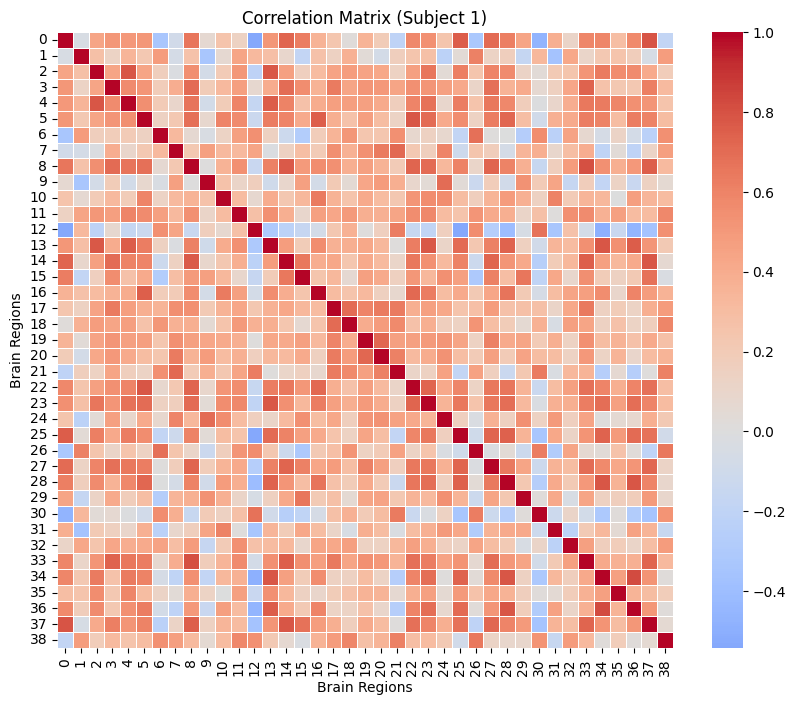

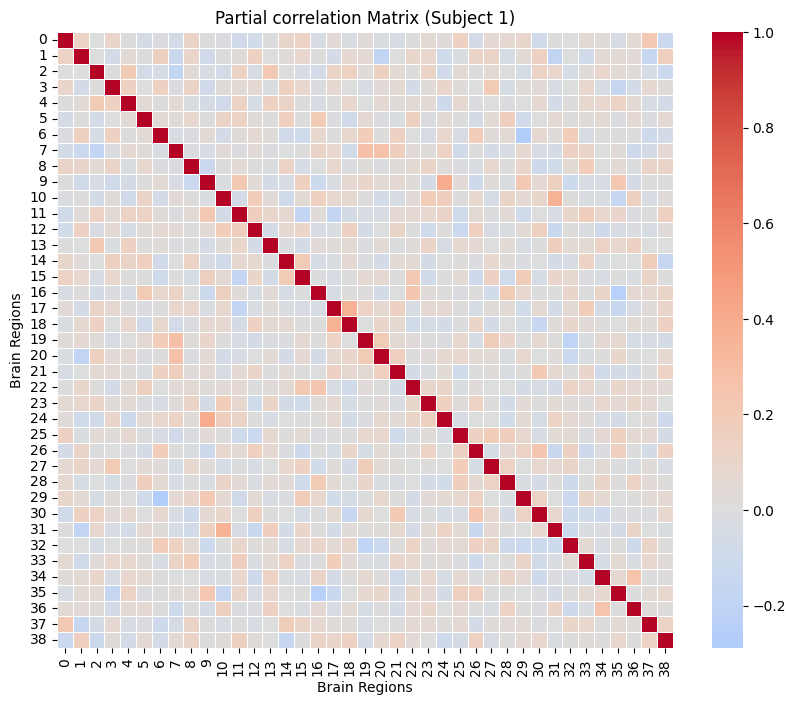

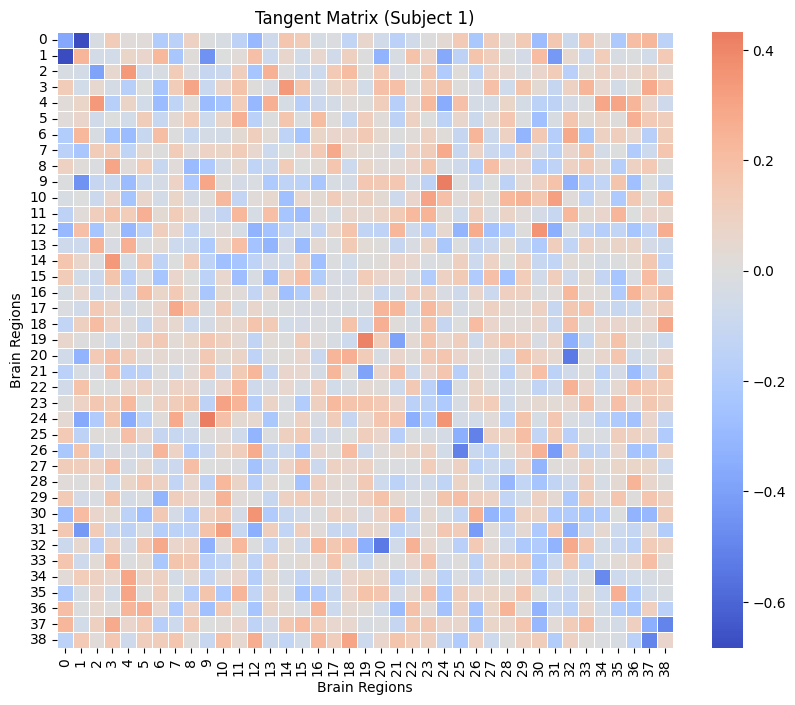

In [13]:
import matplotlib.pyplot as plt #plotting
import seaborn as sns #heatmaps

# Function to plot a correlation matrix
def plot_correlation_matrix(matrix, title): #matrix to be visualized and title
    plt.figure(figsize=(10, 8)) #creates plotsize
    #red = positive correlations
    #blue = negative correlations 
    sns.heatmap(matrix, cmap="coolwarm", center=0, square=True, linewidths=0.5)
    plt.title(title)
    plt.xlabel("Brain Regions")
    plt.ylabel("Brain Regions")
    plt.show()

# loop through correlation methods and extract correlation matrix for subject 1
for method in methods:
    plot_correlation_matrix(correlation_matrices[method][0], f"{method.capitalize()} Matrix (Subject 1)")

1. Full Correlation Matrix (First Image)
   - This measures all possible connections, including both direct and indirect influences.
   - More red and blue areas → Many brain regions work together or opposite to each other.
   - Red means strong connection, blue means opposite activity.
   
   - Helps identify which regions work together as part of large-scale brain networks. (global patterns)


2. Partial Correlation Matrix (Second Image)
   - This only keeps direct relationships, removing any indirect influence.
   - Less red and blue than full correlation → Shows only strong direct connections.
   - More white (weak connections) because weaker interactions are filtered out.

   - Shows which regions interact independently, without interference from others.



3. Tangent Matrix (Third Image)
   - This shows how different Subject 1’s brain connections are compared to a group of people.
   - Not an actual correlation → Instead, it compares this subject’s brain to an average person.
   - More scattered colors → Shows how this brain’s activity differs from the norm.

   - Helps find individual differences in brain connectivity.

## Correlation Matrices for ALL subjects

In [9]:
import numpy as np
from nilearn.connectome import ConnectivityMeasure

# Define different correlation methods
methods = ["correlation", "partial correlation", "tangent"]
correlation_matrices = {method: [] for method in methods}  # Store matrices for ALL subjects

# Compute correlation matrices for ALL subjects
for method in methods:
    connectivity_measure = ConnectivityMeasure(kind=method)
    correlation_matrices[method] = connectivity_measure.fit_transform(time_series)  # Includes all subjects

    # Print shape to confirm computation
    print(f"{method.capitalize()} Matrix shape: {correlation_matrices[method][0].shape}")


Correlation Matrix shape: (39, 39)
Partial correlation Matrix shape: (39, 39)
Tangent Matrix shape: (39, 39)


1. nx.from_numpy_array(matrix):
- Treats the matrix as an adjacency matrix.
- Each brain region (ROI) is a node.
- Each correlation value is an edge weight between two regions.

# Include ALL Subjects

## 1. Load Full Dataset

In [11]:
from nilearn import datasets

# Load dataset WITHOUT restricting to children
dataset = datasets.fetch_development_fmri(n_subjects=None, verbose=1)  # Remove age_group filter

# Check the new counts
num_children = sum(1 for label in dataset.phenotypic["Child_Adult"] if label == "child")
num_adults = sum(1 for label in dataset.phenotypic["Child_Adult"] if label == "adult")

print(f"Number of Children: {num_children}")
print(f"Number of Adults: {num_adults}")


[get_dataset_dir] Dataset found in /Users/anushamourshed/nilearn_data/development_fmri
[get_dataset_dir] Dataset found in /Users/anushamourshed/nilearn_data/development_fmri/development_fmri
[get_dataset_dir] Dataset found in /Users/anushamourshed/nilearn_data/development_fmri/development_fmri
[fetch_single_file] Downloading data from https://osf.io/download/5c8ff3df4712b400183b7092/ ...
[fetch_single_file]  ...done. (2 seconds, 0 min)

[fetch_single_file] Downloading data from https://osf.io/download/5c8ff3e04712b400193b5bdf/ ...
[fetch_single_file]  ...done. (1 seconds, 0 min)

[fetch_single_file] Downloading data from https://osf.io/download/5c8ff3e14712b400183b7097/ ...
[fetch_single_file]  ...done. (2 seconds, 0 min)

[fetch_single_file] Downloading data from https://osf.io/download/5c8ff3e32286e80018c3e42c/ ...
[fetch_single_file]  ...done. (1 seconds, 0 min)

[fetch_single_file] Downloading data from https://osf.io/download/5c8ff3e4a743a9001760814f/ ...
[fetch_single_file]  ...d

## 2. Extract Time-Series Data Using an Atlas

In [16]:
from nilearn.input_data import NiftiMapsMasker

# Load an atlas (predefined brain regions)
atlas = datasets.fetch_atlas_msdl()

# Initialize the masker
masker = NiftiMapsMasker(maps_img=atlas.maps, standardize=True, memory=None)

# Extract time-series data for ALL subjects
time_series = [masker.fit_transform(func_img) for func_img in dataset.func]

# Print the first subject's time-series shape
print(f"Time-series shape for first subject: {time_series[0].shape}")


[get_dataset_dir] Dataset found in /Users/anushamourshed/nilearn_data/msdl_atlas
Time-series shape for first subject: (168, 39)


## 3. Separate Children and Adults

In [19]:
time_series_child = []
time_series_adult = []

# Correctly separate children and adults based on matching labels
for i, (func_img, label) in enumerate(zip(dataset.func, dataset.phenotypic["Child_Adult"])):
    if label == "child":
        time_series_child.append(time_series[i])  # Append the correct time-series
    else:
        time_series_adult.append(time_series[i])

print(f"Number of Children: {len(time_series_child)}")
print(f"Number of Adults: {len(time_series_adult)}")


Number of Children: 122
Number of Adults: 33


### What This Code Does
- Loops through all subjects (dataset.func) and their labels (dataset.phenotypic["Child_Adult"]).
- Checks each subject's label: 
   - If "child", appends the corresponding time-series to time_series_child.
   - Otherwise, appends it to time_series_adult.

- Prints out the total number of subjects in each group to confirm correctness.

## 4. Compute Connectivity Matrices

In [20]:
import numpy as np
from nilearn.connectome import ConnectivityMeasure

# Define different correlation methods
methods = ["correlation", "partial correlation", "tangent"]
correlation_matrices = {"child": {}, "adult": {}}

# Compute correlation matrices separately for children and adults
for method in methods:
    connectivity_measure = ConnectivityMeasure(kind=method)
    
    # Compute matrices for children
    correlation_matrices["child"][method] = connectivity_measure.fit_transform(time_series_child)
    print(f"{method.capitalize()} Matrix shape (Children): {correlation_matrices['child'][method][0].shape}")

    # Compute matrices for adults
    correlation_matrices["adult"][method] = connectivity_measure.fit_transform(time_series_adult)
    print(f"{method.capitalize()} Matrix shape (Adults): {correlation_matrices['adult'][method][0].shape}")


Correlation Matrix shape (Children): (39, 39)
Correlation Matrix shape (Adults): (39, 39)
Partial correlation Matrix shape (Children): (39, 39)
Partial correlation Matrix shape (Adults): (39, 39)
Tangent Matrix shape (Children): (39, 39)
Tangent Matrix shape (Adults): (39, 39)


## 5. Visualize Correlation Matrices

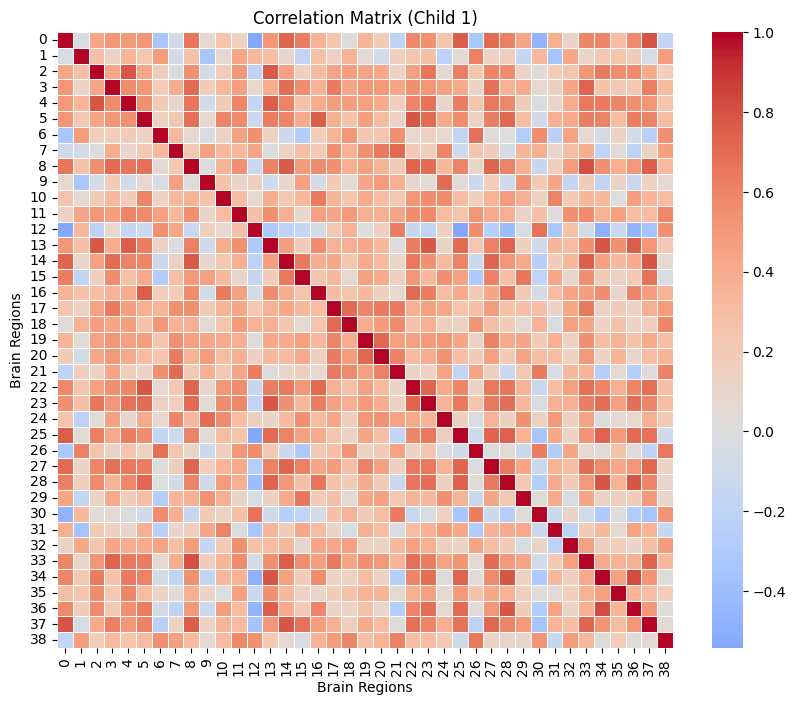

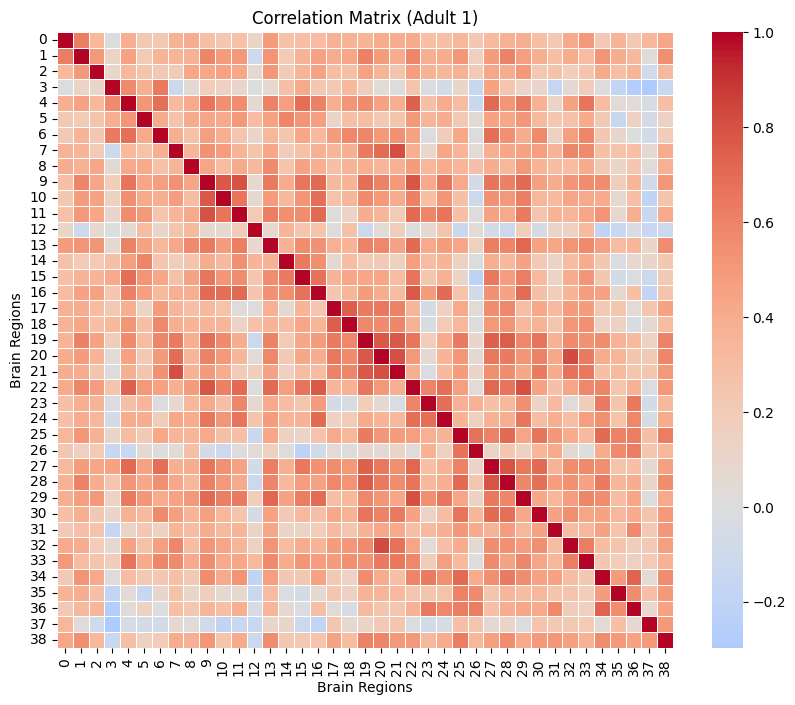

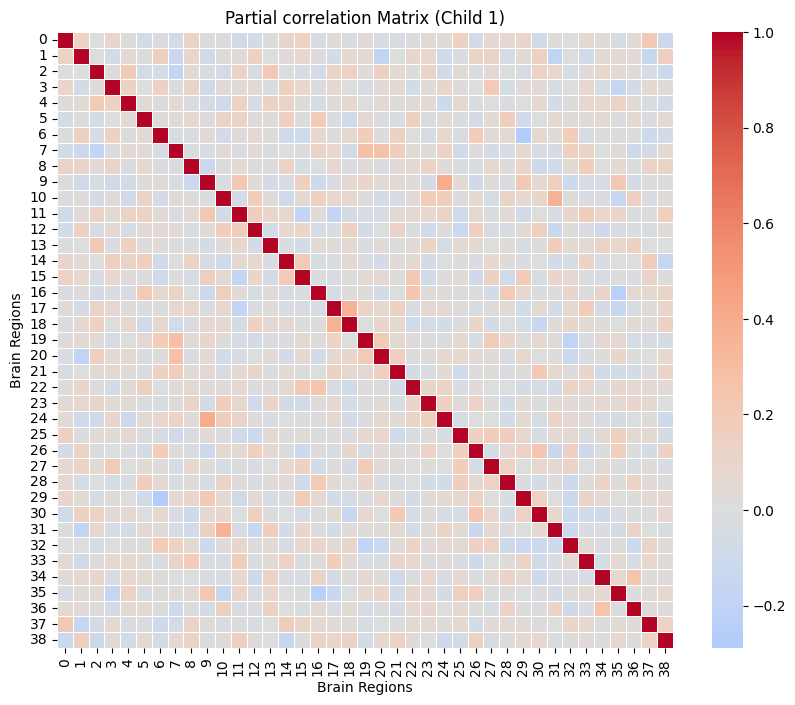

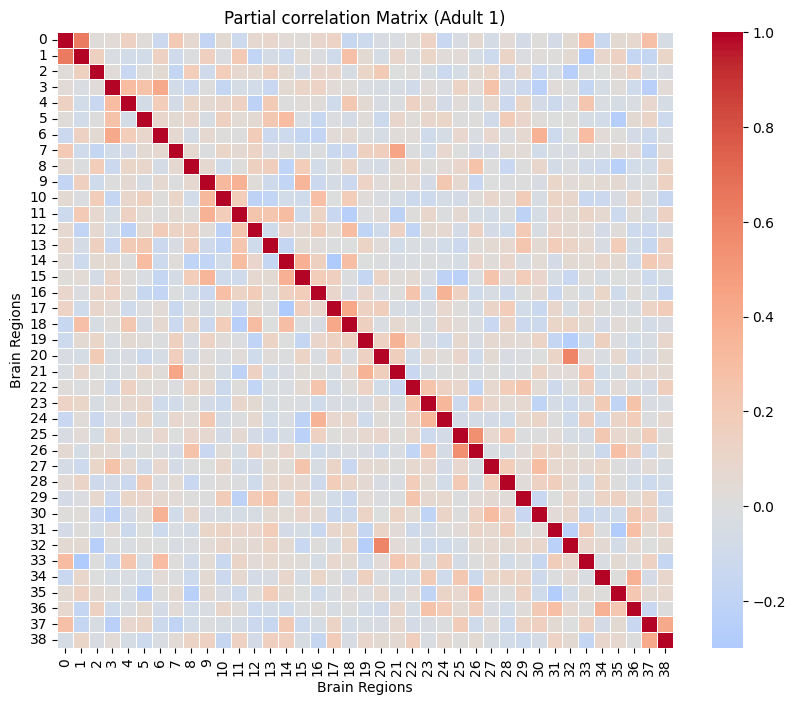

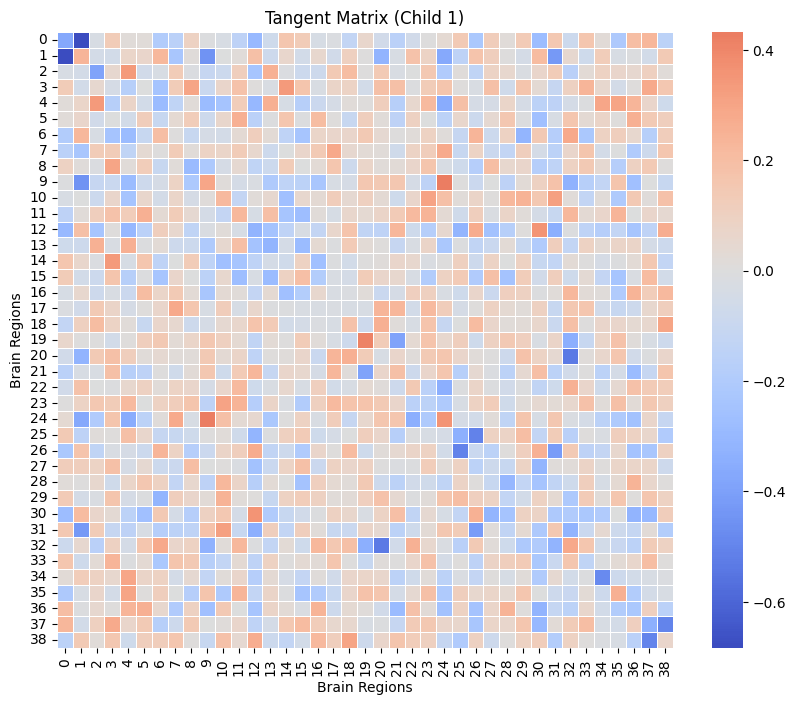

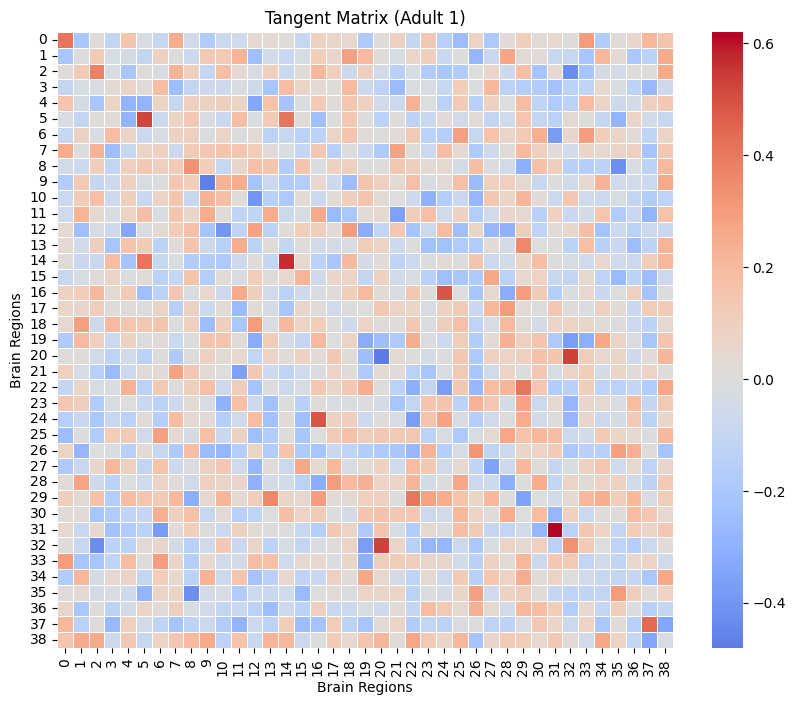

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot a correlation matrix
def plot_correlation_matrix(matrix, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, cmap="coolwarm", center=0, square=True, linewidths=0.5)
    plt.title(title)
    plt.xlabel("Brain Regions")
    plt.ylabel("Brain Regions")
    plt.show()

# Plot correlation matrices for first child and first adult
for method in methods:
    plot_correlation_matrix(correlation_matrices["child"][method][0], f"{method.capitalize()} Matrix (Child 1)")
    plot_correlation_matrix(correlation_matrices["adult"][method][0], f"{method.capitalize()} Matrix (Adult 1)")
